# PROACT Dataset

In [1]:

import config as cfg
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

matplotlib_style = 'default'
import matplotlib.pyplot as plt; plt.style.use(matplotlib_style)
plt.rcParams.update({'axes.labelsize': 'medium',
                    'axes.titlesize': 'medium',
                    'font.size': 14.0,
                    'text.usetex': True,
                    'text.latex.preamble': r'\usepackage{amsfonts} \usepackage{bm}'})

df = pd.read_csv(Path.joinpath(cfg.PROACT_DATA_DIR, 'proact_processed.csv'), index_col=0)
df = df.loc[(df['TTE_Speech'] > 0) & (df['TTE_Swallowing'] > 0)
            & (df['TTE_Handwriting'] > 0) & (df['TTE_Walking'] > 0)
            & (df['TTE_Salivation'] > 0) & (df['TTE_Death'] > 0)] # min time
df = df.loc[(df['TTE_Speech'] <= 1800) & (df['TTE_Swallowing'] <= 1800)
            & (df['TTE_Handwriting'] <= 1800) & (df['TTE_Walking'] <= 1800)
            & (df['TTE_Salivation'] <= 1800) & (df['TTE_Death'] <= 1800)] # 5 years max
event_cols = ['Speech', 'Salivation', 'Swallowing', 'Handwriting', 'Walking', 'Death']

# Rename columns for readability
df = df.rename({"Event_Speech": "Speech",
                "Event_Salivation": "Salivation",
                "Event_Swallowing": "Swallowing",
                "Event_Handwriting": "Handwriting",
                "Event_Walking": "Walking",
                "Event_Death": "Death"}, axis=1)

In [2]:
for event_col in event_cols:
    obs_arr = np.array(df[event_col])
    n_censored = obs_arr.shape[0] - obs_arr.sum()
    print(f"Number of samples: {len(df)}")
    print(f"Number of censored/uncensored: {n_censored}/{obs_arr.shape[0]-n_censored}")
    print(f"{round((obs_arr.shape[0]-n_censored) / obs_arr.shape[0] * 100, 2)}% of records are uncensored\n")

Number of samples: 3694
Number of censored/uncensored: 2385/1309
35.44% of records are uncensored

Number of samples: 3694
Number of censored/uncensored: 2581/1113
30.13% of records are uncensored

Number of samples: 3694
Number of censored/uncensored: 2618/1076
29.13% of records are uncensored

Number of samples: 3694
Number of censored/uncensored: 1855/1839
49.78% of records are uncensored

Number of samples: 3694
Number of censored/uncensored: 1499/2195
59.42% of records are uncensored

Number of samples: 3694
Number of censored/uncensored: 2845/849
22.98% of records are uncensored



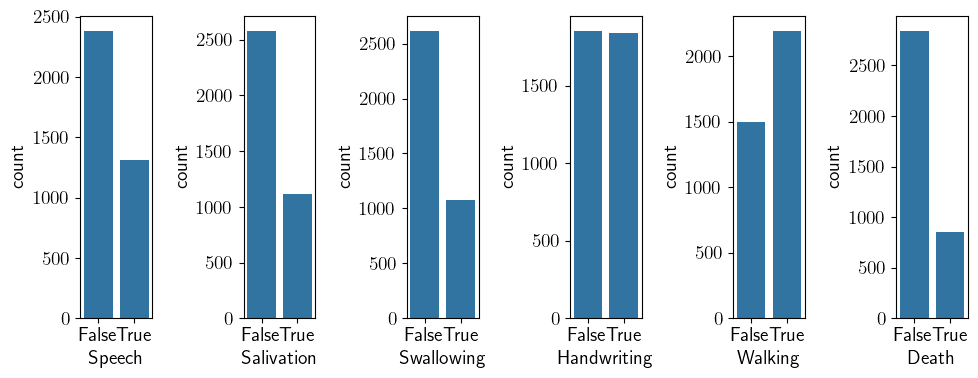

In [3]:
fig, axs = plt.subplots(ncols=len(event_cols), figsize=(10,4))
for i, col in enumerate(event_cols):
    sns.countplot(x=col, data=df, ax=axs[i])
plt.tight_layout()
plt.show()

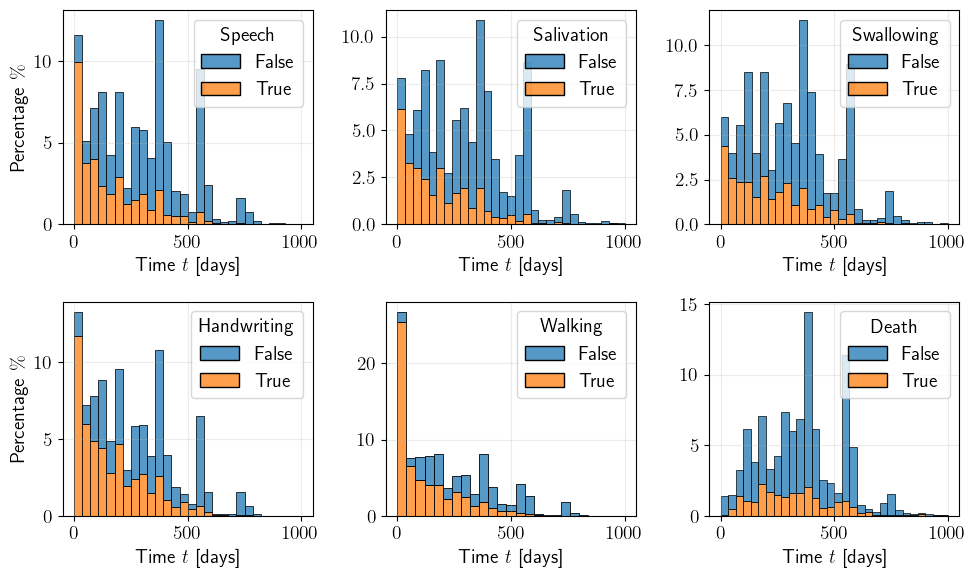

In [9]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))
axs = axs.flatten()
for i, col in enumerate(event_cols):
    event = df[[f'TTE_{col}', f'{col}']]
    sns.histplot(x=f'TTE_{col}', data=event, hue=f'{col}', multiple="stack", bins="auto", ax=axs[i], binrange=(0, 1000), stat="percent")
    axs[i].set_xlabel("Time $t$ [days]")
    if i % 3 == 0:  # Add ylabel only to the first column in each row
        axs[i].set_ylabel("Percentage $\%$")
    else:
        axs[i].set_ylabel("")
    axs[i].grid(True, alpha=0.25)
plt.tight_layout()
plt.show()